## Sensitivity Test of Domain-averaged Precipitation
- Constrain precipitation by satellite-based cloud-top height distribution: only consider clouds below 4km (higher cloud-top heights such as deep convection and other non-cumulus clouds are therefore excluded)
- Find the precipitation efficiency $x$

### Python packages

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import glob
from pathlib import Path
import colormaps as cmaps

### Functions

In [2]:
# Latent heat of vaporization of water as a function of temperature [K]
def Lv(T):
    return 2.501e6 + (Cpv - Cw) * (T - T0) # [J/kg]

# Wexler/Buck 1981 formula (with enhancement factor at standard pressure)
def es_wexler(T_C, P=1013.25):  # P in hPa
    return 1e2 * 6.1121 * (1.0007 + 3.46e-6 * P) * np.exp((17.502 * T_C) / (240.97 + T_C))

# Saturation vapor pressure calculations
def q_sat(T_C, p=101325):  # p in Pa (default = 1013.25 hPa)
    epsilon = Rd / Rv  # ratio of gas constants
    #es = es_clausius_clapeyron(T_C)
    #es = es_tetens(T_C)
    es = es_wexler(T_C)
    return (epsilon * es) / (p - (1 - epsilon) * es)

# Total water content calculation
def q_total(ae, dz, x, qs, qm, q_zcb, izcb):
    qtilde = (1 - x) * qm + x * qs

    qt = qtilde.copy()
    qt[0:izcb+1] = q_zcb  # set sub-cloud specific humidity
                          # Python is start inclusive, end exclusive, so must use izcb+1
                          # So qt[0:izcb+1] includes qt[izcb]
    for iz in range(izcb, len(qt)-1):
        if qt[iz] > qs[iz]:
            a1 = ae * dz
            Q1 = (qtilde[iz+1] + qtilde[iz]) / 2
            qt[iz+1] = ( (1-a1/2) * qt[iz] + a1*Q1 ) / (1 + a1/2)
        else:
            a2 = (1 - x) * ae * dz
            Q2 = (qm[iz+1] + qm[iz]) / 2
            qt[iz+1] = ( (1-a2/2) * qt[iz] + a2*Q2 ) / (1 + a2/2)
    return qt

def cloudflux_downward(ae, dz, x, ql, qm, qs, Ft, izcb, izct):
    Q = x * ae * ql / (qs - qm) * dz
    Fcld = Ft.copy()
    Fcld[:izct] = np.nan
    for iz in range(izct, izcb-1, -1):
        Fcld[iz] = (Ft[iz] - Ft[iz+1] + Fcld[iz+1] * (1 + Q[iz+1]/2)) / (1 - Q[iz]/2)
    return Fcld

### Data
- GOES-16 satellite data
    - https://satcorps.larc.nasa.gov/prod/exp/atomic-2020/visst-pixel-netcdf/2020
    - NASA-Langley cloud and radiation products are produced using Satellite Cloud Observations and Radiative Property retrieval System (SatCORPS). REFERENCE:Minnis, P., et al. , 2008: Near-real time cloud retrievals from operational and research meteorological satellites. Proc. SPIE Europe Remote Sens. 2008, Cardiff, Wales, ID, 15-18 September, 7107, No. 2, 8pp. http://satcorps.larc.nasa.gov/site/doc-library/99-Minnis.etal.SPIE.abs.08.pdf. Additional references on calibration, validation can be found at http://satcorps.larc.nasa.gov/references
    - All of the datasets provided on this website are part of ongoing research projects. Users of the data for research leading to conference-level or peer-reviewed publications should contact Dr. William L. Smith Jr. (william.l.smith@nasa.gov) before publishing any papers that include data from this site. The source of the data should be properly acknowledged and/or co-authorship should be offered depending on the level of documentation and contribution of the particular dataset.If only the satellite imagery are used then we ask only for a simple acknowledgment: \"the images were obtained from the NASA Langley Cloud and Radiation Research Group, http://satcorps.larc.nasa.gov \". For any derived cloud, icing, and radiation products, it is in the best interest of individual researchers who use these datasets to ensure that they are using the latest and highest quality products available. Either Dr. Smith or other group members can provide the proper references, caveats, or level of participation needed for any given request.
- Ronald Brown ship measurement data (Quinn et al., 2021; https://doi.org/10.5194/essd-13-1759-2021)
    - https://www.ncei.noaa.gov/archive/accession/ATOMIC-2020
    - The Atlantic Tradewind Ocean-Atmosphere Mesoscale Interaction Campaign (ATOMIC) was a field campaign held January-February 2020 in the tropical North Atlantic east of Barbados. The campaign, the U.S. complement to the European field campaign called EUREC4A, was aimed at better understanding cloud and air-sea interaction processes. ATOMIC included in measurements from a NOAA WP-3D Orion "Hurricane Hunter" aircraft, the research ship Ronald H. Brown, and unpiloted vehicles launched from Barbados and from the Ronald H. Brown.

In [3]:
# GOES-16 data
gdir = "/Users/huang/Data/SimonsCAT/ATOMIC/GOES-16/2020"
dsg  = xr.open_dataset(Path(gdir, "goes16_binned_low4km_20200115_20200219.nc"))

# Ronald Brown data
rdir = "/Users/huang/Data/SimonsCAT/ATOMIC/RonBrown"
dsr  = xr.open_dataset(Path(rdir, "RonBrown_radiosondes.nc"))
dss  = xr.open_dataset(Path(rdir, "RonBrown_10min_flux.nc"))

### Variables

In [4]:
# Variables from GOES-16 data
rfv_nrm = dsg['rfv_nrm'].values
rfv_acc = dsg['rfv_acc'].values
cth_bin = dsg['cth_bin'].values
# vf      = dsg['valid_fraction'].values

# Variables from Ronald Brown data
# Mean profiles over soundings
z    = dsr['alt'].values       # shape (alt,) [m]
tam  = dsr['ta'].mean(dim='sounding', skipna=True).values # mean air temperature [K]
# thm  = dsr['theta'].mean(dim='sounding', skipna=True).values
qm   = dsr['q'].mean(dim='sounding', skipna=True).values # mean specific humidity [kg/kg]
pm   = dsr['p'].mean(dim='sounding', skipna=True).values # mean air pressure [Pa]

# Mean fluxes over 10-min intervals
# lhf  = dss['hl_bulk'].values.squeeze()  # surface downward latent heat flux [W/m^2]
pr   = dss['prate'].values.squeeze()    # precipitation rate [mm/hr]
# ep   = dss['evap'].values.squeeze()    # evaporation rate [mm/hr]
rho  = dss['rhoair10'].values.squeeze()  # surface air density at 10-m [kg/m^3]
tair = dss['tair_ship'].values.squeeze()  # surface air temperature [degC]

In [5]:
# Constants
Cpv     = 1870   # Specific heat capacity of water vapor at constant pressure [J/kg/K] Bolton
Cw      = 4190   # Specific heat capacity of liquid water at constant pressure [J/kg/K] Bolton
Rv      = 461.5  # Gas constant for water vapor [J/kg/K]
Rd      = 287.04 # Gas constant for dry air [J/kg/K]
T0      = 273.15 # Reference temperature [K]

zi      = 3000   # Inversion height [m]
ztop    = 4000   # Top of trade cumulus cloud layer [m]
divg    = 1e-6   # Divergence of vertical velocity [s^-1]
# rho_sfc = 1.16   # Surface density [kg/m^3] obtained from surface data instead

Ecb     = 170    # Evaporation rate at cloud base [W/m^2]

In [6]:
# Variables derived from mean profiles
qs   = q_sat(tam - T0, pm)  # saturation specific humidity
dz   = (z[1] - z[0])        # vertical grid spacing in m
# dqdz = np.gradient(qm, dz)  # vertical gradient of specific humidity (central difference)
dqdz = np.diff(qm) / dz     #                                        (forward difference)

# Lv_m = Lv(np.nanmean(tam[z <= ztop])) # latent heat of vaporization avg lower than ztop [2.47e+6 J/kg]
Lvsfc_m = Lv(np.nanmean(tair) + T0)  # latent heat of vaporization at surface [2.44e+6 J/kg]

rho_sfc = np.nanmean(rho)  # surface air density [kg/m^3]

# Latent heat of vaporization times density avg lower than ztop
# rho_L = np.nanmean(pm[z <= ztop]) / (Rd * np.nanmean(tam[z <= ztop])) * Lv_m # [kg/m^3 J/kg]
# Latent heat of vaporization times surface density
rhosfc_L = rho_sfc * Lvsfc_m

In [7]:
# Calculations: large-scale advections (prescribed, i.e., the A term)
# Vertical velocity w(z) = -divg * z [m/s]
# Vertical moisture advection (subsidence drying: -w(z) * dq/dz)
w_dqdz = -( -divg * np.minimum(z[:-1], zi) ) * dqdz  # [1/s] # use z if dqdz is central difference

# Horizontal moisture advection (moisture convergence: ui * dq/dxi)
u_dqdx = -1.7e-8 * np.maximum(0, (ztop - z[:-1])/ztop)

ls_adv = w_dqdz + u_dqdx

### Use $x$ and $\alpha+\epsilon$ to infer precipitation at surface
- With pre-selected precipitation of 25.4 $Wm^{-2}$ from surface observational domain average.
- Cloud-base height: 700 m
- Precipitation efficiency ($x$) range: 0 to 1
- Total sink rate (auto-conversion $\alpha$ and entrainment $\epsilon$ coefficients) range: 0.5 to 5

$x=\alpha/(\alpha+\epsilon)$

In [8]:
# Since this preciptiation is observed at surface, we convert it to W/m2 using surface density (rhosfc_L)
print('Domain-averaged precipitation from Ronald Brown surface observations:', np.round(np.nanmean(pr), 2), 
        'mm/hr =', np.round(np.nanmean(pr)*rhosfc_L/3600, 2), 'W/m2')

Domain-averaged precipitation from Ronald Brown surface observations: 0.03 mm/hr = 25.4 W/m2


In [9]:
# Calculations
Fcb = Ecb / rhosfc_L - np.nanmean(pr) / 3600 # [kg/m^2/s]
zcb = 700
x_range = np.arange(0, 1.01, 0.01)
ae_range = 1e-3 * np.arange(0.5, 5.01, 0.01)

pr_pred = np.zeros((len(x_range), len(ae_range))) # predicted precipitation flux at cloud-base [kg/m^2/s]
cth_pred = np.zeros((len(x_range), len(ae_range))) # predicted cloud-top height [m]
ac = np.zeros((len(x_range), len(ae_range)))
ec = np.zeros((len(x_range), len(ae_range)))
for ix in range(len(x_range)):
    for iae in range(len(ae_range)):
        # print(f"Case with α+ϵ={ae_range[iae]*1e+3} 1/km and x={x_range[ix]:.2f}")
        ae = ae_range[iae]
        x = x_range[ix]

        izcb = np.where(z >= zcb)[0][0]  # find index where height is greater than or equal to zcb
        q_zcb = qs[izcb]  # specific humidity at cloud base height

        # Integrate total flux balancing subsidence drying and horizontal advection from cloud base
        Ft = qm.copy()
        Ft[1:izcb] = np.nan
        ls_adv_cumsum = np.concatenate( ([0], np.cumsum(ls_adv[izcb:] * dz)) )
        Ft[izcb:] = Fcb + ls_adv_cumsum

        # Calculate total water content
        qt = q_total(ae, dz, x, qs, qm, q_zcb, izcb)
        ql = np.maximum(qt - qs, 0.0)           # cloud liquid water content

        # Find the cloud-top height where ql goes to zero above the cloud base
        izct = np.where(ql[izcb+1:] == 0)[0][0] + izcb

        # Calculations: cloud fluxes for control case
        Fcld = cloudflux_downward(ae, dz, x, ql, qm, qs, Ft, izcb, izct)
        Fpr = Fcld - Ft # Precipitation flux must be zero above cloud top

        pr_pred[ix, iae] = Fpr[izcb]
        cth_pred[ix, iae] = z[izct]
        ac[ix, iae] = x * ae       # autoconversion coefficient
        ec[ix, iae] = (1 - x) * ae # entrainment coefficient

In [10]:
# Only keep cth_pred > 4000
prwm2 = rhosfc_L * pr_pred # convert to W/m^2 (since this preciptation flux is at cloud-base, we use rho_L instead of rhosfc_L)
print([np.nanmin(prwm2), np.nanmax(prwm2)])

prwm2keep = np.where((cth_pred <= 4000), prwm2, np.nan)
print([np.nanmin(prwm2keep), np.nanmax(prwm2keep)])

wm2_levels = np.arange(0, 105, 5) # for contour levels

# Only make cth_pred > 4000 NaN
cthkeep = np.where((cth_pred <= 4000), cth_pred, np.nan)

print([np.nanmin(cthkeep), np.nanmax(cthkeep)])
cth_levels = np.arange(700, 4000+100, 200)/1000 # for contour levels

[0.0, 1.1834970548723114e+19]
[0.0, 231.56405459880176]
[700.0, 3400.0]


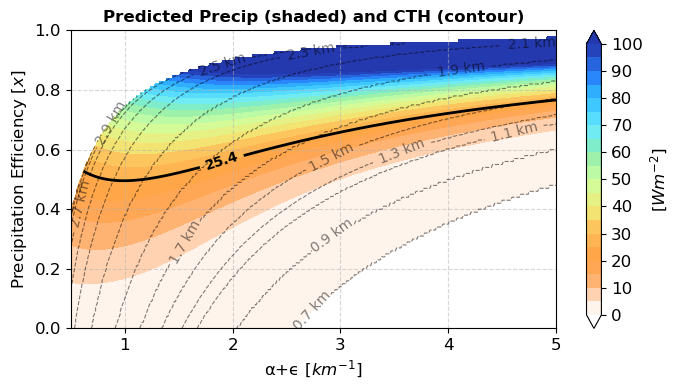

In [11]:
# Plot predicted precipitation and cloud-top height
plt.figure(figsize=(7, 4))

plt.contourf(ae_range * 1e+3, x_range, prwm2keep, levels=wm2_levels, 
             cmap=cmaps.cmp_haxby_r, extend='both')
cb = plt.colorbar()
cb.set_label(r'[$Wm^{-2}$]', fontsize=12)
cb.set_ticks(np.arange(0, 105, 10))
cb.set_ticklabels(np.arange(0, 105, 10), fontsize=12)

cs_pr = plt.contour(ae_range * 1e+3, x_range, prwm2keep, 
            levels=[rhosfc_L*np.nanmean(pr)/3600], colors='k',
            linestyles='-', linewidths=2)
lb = plt.clabel(cs_pr, fmt=lambda v: f"{v:.1f}", colors='k', fontsize=10)
for ilb in lb:
    ilb.set_fontweight('bold')

cs_cth = plt.contour(ae_range * 1e+3, x_range, cthkeep/1000, levels=cth_levels, colors='k',
            linestyles='--', linewidths=0.8, alpha=0.5)
plt.clabel(cs_cth, fmt=lambda v: f"{v:.1f} km", colors='k', fontsize=10)

plt.xlabel(r'α+ϵ [$km^{-1}$]', fontsize=12)
plt.ylabel(f'Precipitation Efficiency [$x$]', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Predicted Precip (shaded) and CTH (contour)', fontsize=12, fontweight='bold')
plt.grid(linestyle='--', alpha=0.5)

plt.tight_layout()

### Project cloud fraction (inferred from the GOES-16 cloud-top height distribution) onto this diagram

In [12]:
# Averaging 1192 profiles of weighted cloud-top height distribution
rfv_nrm_avg = rfv_nrm.mean(axis=0)
rfv_acc_avg = rfv_acc.mean(axis=0) # cloud fraction

In [13]:
# Projecting cloud fraction onto the x-ae diagram
idtop = np.zeros(len(x_range))
matched_nrm = np.zeros((len(x_range), len(ae_range)))
matched_acc = np.zeros((len(x_range), len(ae_range)))
pr_weighted = np.zeros((len(x_range), len(ae_range)))
pr_weighted_sum = np.zeros(len(x_range))
for ix in range(len(x_range)):
    idtop0 = np.where(cth_pred[ix,:]<4000)[0]
    if np.where(cth_pred[ix,:]<4000)[0].size == 0:
        idtop[ix] = np.nan
    else:
        idtop[ix] = idtop0[0]
        matched_nrm[ix, int(idtop[ix]):] = np.interp(cth_pred[ix, int(idtop[ix]):], cth_bin*1000, rfv_nrm_avg)
        matched_acc[ix, int(idtop[ix]):] = np.interp(cth_pred[ix, int(idtop[ix]):], cth_bin*1000, rfv_acc_avg)
        pr_weighted[ix, int(idtop[ix]):] = (rhosfc_L * pr_pred[ix, int(idtop[ix]):] * matched_nrm[ix, int(idtop[ix]):])
        pr_weighted_sum[ix] = pr_weighted[ix, int(idtop[ix]):].sum()/matched_acc[ix, -1]
        # print('X = ', x_range[ix], '; Precip = ', np.round(pr_weighted_avg[ix],2), 'Wm^-2')

acc_levels = np.arange(1, 10.1, 1)

# Find the precipitation efficiency
pr_avg = np.nanmean(pr) * rhosfc_L / 3600 # Wm^-2
imax = np.argmax(pr_weighted_sum)
x_final = np.interp(pr_avg, pr_weighted_sum[:imax+1], x_range[:imax+1])

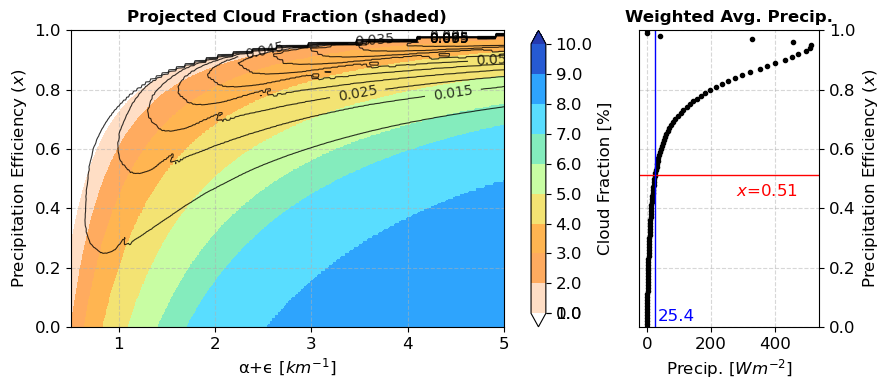

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4), gridspec_kw={'width_ratios': [3, 1]})

# Cloud fraction
cs = ax1.contourf(ae_range * 1e+3, x_range, matched_acc*100, levels=acc_levels, 
            cmap=cmaps.cmp_haxby_r, extend='both')

cb = fig.colorbar(cs, ax=ax1)
cb.set_label(r'Cloud Fraction [%]', fontsize=12)
cb.set_ticks(np.arange(0, 10.1, 1))
cb.set_ticklabels(np.arange(0, 10.1, 1), fontsize=12)

cs_pr = ax1.contour(ae_range * 1e+3, x_range, pr_weighted, levels=np.arange(0.005, 0.105, 0.01), colors='k',
            linestyles='-', linewidths=0.8, alpha=0.8)
ax1.clabel(cs_pr, fmt=lambda v: f"{v:.3f}", colors='k', fontsize=10)

# cs_cth = ax1.contour(ae_range * 1e+3, x_range, cthkeep/1000, levels=cth_levels, colors='k',
#             linestyles='--', linewidths=0.8, alpha=0.5)
# ax1.clabel(cs_cth, fmt=lambda v: f"{v:.1f} km", colors='k', fontsize=10)

ax1.set_xlabel(r'α+ϵ [$km^{-1}$]', fontsize=12)
ax1.set_ylabel(f'Precipitation Efficiency ($x$)', fontsize=12)
ax1.set_title(rf'Projected Cloud Fraction (shaded)', fontsize=12, fontweight='bold')

ax1.tick_params(axis='x', labelsize=12)
ax1.tick_params(axis='y', labelsize=12)
ax1.grid(linestyle='--', alpha=0.5)

# Weighted precipitation
ax2.plot(pr_weighted_sum, x_range, '.', color='k')
ax2.axhline(x_final, color='r', linewidth=1)
ax2.axvline(pr_avg, color='b', linewidth=1)

ax2.set_ylim(0, 1)

ax2.set_xlabel(r'Precip. [$Wm^{-2}$]', fontsize=12)
ax2.set_ylabel(f'Precipitation Efficiency ($x$)', fontsize=12)
ax2.set_title(rf'Weighted Avg. Precip.', fontsize=12, fontweight='bold')
ax2.text(280, 0.44, f'$x$={np.round(x_final, 2)}', fontsize=12, color='r')
ax2.text(35, 0.02, f'{np.round(pr_avg, 2)}', fontsize=12, color='b')

ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right')
ax2.tick_params(axis='x', labelsize=12)
ax2.tick_params(axis='y', labelsize=12)
ax2.grid(linestyle='--', alpha=0.5)

plt.tight_layout()

### Final Plots
- (1) Precipitation

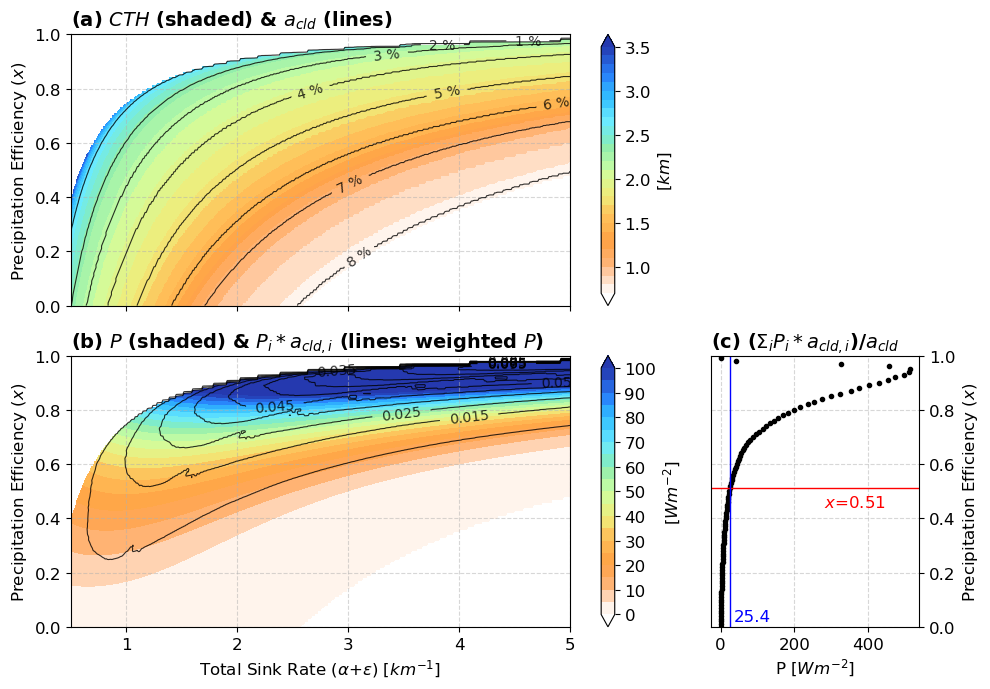

In [75]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 7), gridspec_kw={'width_ratios': [3, 1]})

# Cloud fraction and clout-top height
cs_cth = ax1.contourf(ae_range * 1e+3, x_range, cthkeep/1000, levels=np.arange(700, 3500+100, 100)/1000, 
             cmap=cmaps.cmp_haxby_r, extend='both')

cb = fig.colorbar(cs_cth, ax=ax1)
cb.set_label(f'[$km$]', fontsize=12)
cb.set_ticks(np.arange(1000, 3500+100, 500)/1000)
cb.set_ticklabels(np.arange(1000, 3500+100, 500)/1000, fontsize=12)

ax1.set_xticklabels('')
ax1.tick_params(axis='x', labelsize=12)
ax1.tick_params(axis='y', labelsize=12)
ax1.grid(linestyle='--', alpha=0.5)
ax1.set_ylabel(f'Precipitation Efficiency ($x$)', fontsize=12)
ax1.set_title(rf'(a) $CTH$ (shaded) & $a_{{cld}}$ (lines)', fontsize=14, fontweight='bold', loc='left')

cs_cf = ax1.contour(ae_range * 1e+3, x_range, matched_acc*100, levels=acc_levels, colors='k',
            linestyles='-', linewidths=0.8, alpha=0.8)
ax1.clabel(cs_cf, fmt=lambda v: f"{v:.0f} %", colors='k', fontsize=10)

ax2.axis('off')

# Precipitation
cs = ax3.contourf(ae_range * 1e+3, x_range, prwm2keep, levels=wm2_levels, 
             cmap=cmaps.cmp_haxby_r, extend='both')

cb = fig.colorbar(cs, ax=ax3)
cb.set_label(r'[$Wm^{-2}$]', fontsize=12)
cb.set_ticks(np.arange(0, 105, 10))
cb.set_ticklabels(np.arange(0, 105, 10), fontsize=12)

cs_pr = ax3.contour(ae_range * 1e+3, x_range, pr_weighted, levels=np.arange(0.005, 0.105, 0.01), colors='k',
            linestyles='-', linewidths=0.8, alpha=0.8)
ax3.clabel(cs_pr, fmt=lambda v: f"{v:.3f}", colors='k', fontsize=10)

ax3.set_xlabel(r'Total Sink Rate ($\alpha$+$\epsilon$) [$km^{-1}$]', fontsize=12)
ax3.set_ylabel(f'Precipitation Efficiency ($x$)', fontsize=12)
ax3.set_title(rf'(b) $P$ (shaded) & $P_{{i}}*a_{{cld, i}}$ (lines: weighted $P$)', fontsize=14, fontweight='bold', loc='left')

ax3.tick_params(axis='x', labelsize=12)
ax3.tick_params(axis='y', labelsize=12)
ax3.grid(linestyle='--', alpha=0.5)

# Weighted precipitation
ax4.plot(pr_weighted_sum, x_range, '.', color='k')
ax4.axhline(x_final, color='r', linewidth=1)
ax4.axvline(pr_avg, color='b', linewidth=1)

ax4.set_ylim(0, 1)

ax4.set_xlabel(r'P [$Wm^{-2}$]', fontsize=12)
ax4.set_ylabel(f'Precipitation Efficiency ($x$)', fontsize=12)
ax4.set_title(rf'(c) ($\Sigma_{{i}}$$P_{{i}}*a_{{cld, i}}$)/$a_{{cld}}$', fontsize=14, fontweight='bold', loc='left')
ax4.text(280, 0.44, f'$x$={np.round(x_final, 2)}', fontsize=12, color='r')
ax4.text(35, 0.02, f'{np.round(pr_avg, 2)}', fontsize=12, color='b')

ax4.yaxis.tick_right()
ax4.yaxis.set_label_position('right')
ax4.tick_params(axis='x', labelsize=12)
ax4.tick_params(axis='y', labelsize=12)
ax4.grid(linestyle='--', alpha=0.5)

plt.tight_layout()

In [16]:
xplot = np.round(x_final, 2)
xloc = np.where(x_range == xplot)[0][0]

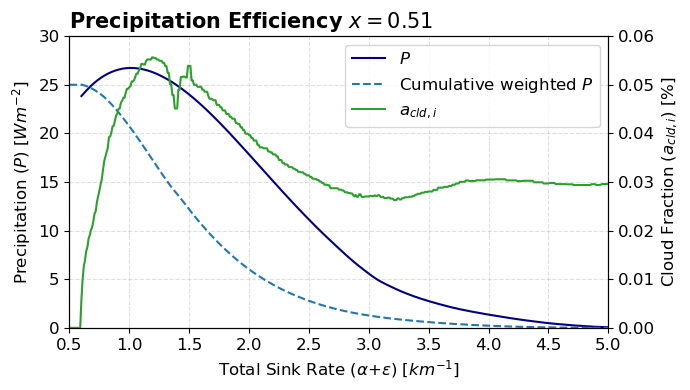

In [71]:
fig, ax1 = plt.subplots(figsize=(7, 4))

x = ae_range * 1e3

# LEFT y-axis (e.g., W m^-2)
l1, = ax1.plot(x, prwm2keep[xloc, :], '-', color='navy', label=r'$P$')
l2, = ax1.plot(x, np.flip(np.cumsum(np.flip(pr_weighted[xloc, :])))/matched_acc[xloc, -1], '--', color='tab:blue', label=r'Cumulative weighted $P$')
ax1.set_xlim(0.5, 5)
ax1.set_ylim(0, 30)
ax1.set_xlabel(r'Total Sink Rate ($\alpha$+$\epsilon$) [$km^{-1}$]', fontsize=12)
ax1.set_ylabel(r'Precipitation ($P$) [$Wm^{-2}$]', fontsize=12)
ax1.tick_params(axis='y', labelsize=12)
ax1.tick_params(axis='x', labelsize=12)
ax1.grid(linestyle='--', alpha=0.4)
ax1.set_title(rf'Precipitation Efficiency $x={xplot}$', fontsize=15, fontweight='bold', loc='left')

# RIGHT y-axis
ax2 = ax1.twinx()
l3, = ax2.plot(x, matched_nrm[xloc, :]*100, '-', color='tab:green', label=r'$a_{cld, i}$')
# l3, = ax2.plot(x, pr_weighted[xloc, :], '--', color='navy', label=r'$P·a_{cld}$')
ax2.set_ylabel(r'Cloud Fraction ($a_{cld, i}$) [%]', fontsize=12)
ax2.tick_params(axis='y', labelsize=12)
ax2.tick_params(axis='x', labelsize=12)

# keep same x-limits if you set them later
ax2.set_xlim(ax1.get_xlim())
ax2.set_ylim(0, 0.06)

# one combined legend
lines = [l1, l2, l3]
labels = [ln.get_label() for ln in lines]
ax1.legend(lines, labels, loc='best', fontsize=12)

plt.tight_layout()
